In [ ]:
'''
Goal: Understand dataset composition, class imbalance, and visual characteristics of the X-ray images
'''

Split TRAIN
NORMAL -> 1341
PNEUMONIA -> 3875
Split TEST
NORMAL -> 234
PNEUMONIA -> 390
Split VAL
NORMAL -> 8
PNEUMONIA -> 8


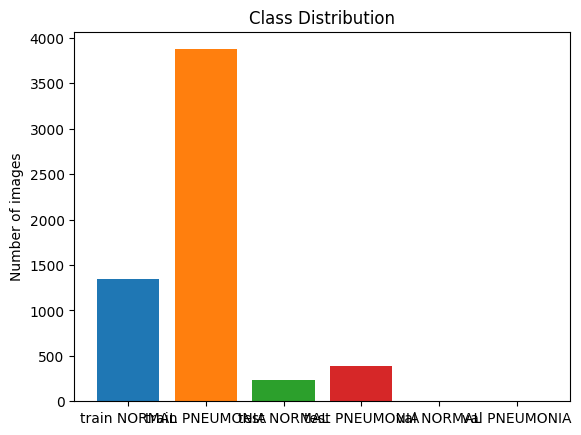

In [4]:
from pneumonia_x_ray_images_classifier.data.make_dataset import get_latest_pneumonia_dataset
import matplotlib.pyplot as plt


dataset_path = get_latest_pneumonia_dataset()

for split in ["train", "test", "val"]:
    print(f"Split {split.upper()}")
    for cls in ["NORMAL", "PNEUMONIA"]:
        path = dataset_path / split / cls
        files = list(path.glob("*"))
        print(cls, "->", len(files))
        plt.bar(f"{split} {cls}", len(files))

plt.title("Class Distribution")
plt.ylabel("Number of images")
plt.show()
    

The training set contains 1,341 normal images and 3,875 pneumonia images, indicating significant class imbalance.
The test set contains 234 normal and 390 pneumonia images.
The provided validation set contains only 16 images in total, which is insufficient for reliable model selection.

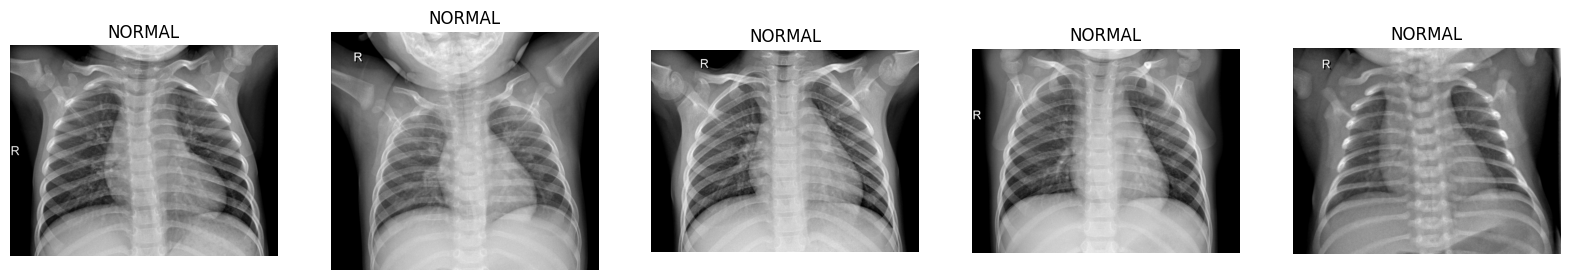

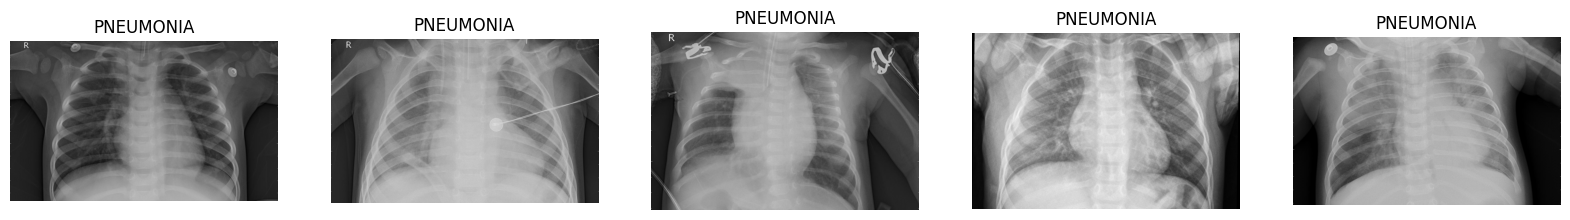

In [15]:
from PIL import Image
import random


def show_images(split, cls, n=5):
    files = list((dataset_path / split / cls).glob("*"))
    samples = random.sample(files, n)
    
    plt.figure(figsize=(20, 20))
    for i, sample in enumerate(samples):
        img = Image.open(sample)
        plt.subplot(1, 5, i + 1)
        plt.imshow(img, cmap="gray")
        plt.title(cls)
        plt.axis("off")
        
    plt.show()

show_images("train", "NORMAL")
show_images("train", "PNEUMONIA")

In [16]:
from collections import Counter

sizes = []

for img_path in (dataset_path / "train").rglob("*.jpeg"):
    with Image.open(img_path) as img:
        sizes.append(img.size)

Counter(sizes).most_common(5)

[((1072, 648), 7),
 ((1080, 728), 6),
 ((976, 672), 5),
 ((1008, 704), 5),
 ((1064, 760), 5)]

We will need to resize

In [18]:
img = Image.open(next((dataset_path / "train" / "NORMAL").glob("*.*")))
img.mode

'L'

Grayscale (1 channel)

In [19]:
import numpy as np

def intensity_stats(cls, n=200):
    pixels = []
    files = list((dataset_path / "train" / cls).glob("*.*"))[:n]
    for f in files:
        img = np.array(Image.open(f).convert("L"))
        pixels.append(img.flatten())
    pixels = np.concatenate(pixels)
    return pixels.min(), pixels.max(), pixels.mean(), pixels.std()

for cls in ["NORMAL", "PNEUMONIA"]:
    print(cls, intensity_stats(cls))


NORMAL (np.uint8(0), np.uint8(255), np.float64(123.80219564610685), np.float64(64.55966271136654))
PNEUMONIA (np.uint8(0), np.uint8(255), np.float64(125.208612612697), np.float64(62.14336757113332))


Pixel intensity analysis showed that both normal and pneumonia images span the full 0–255 grayscale range, with similar mean intensities and standard deviations. Proves that pneumonia detection cannot rely on global brightness differences alone

EDA revealed that the provided validation set contains only 16 images, which is insufficient for reliable model selection. Therefore, the training set will be split such that 80% is used for training and 20% for validation. The original test set will remain unchanged and will be used only for final evaluation.